# Enhanced Food Delivery Time Prediction System

**Notebook outline:**

This notebook implements an enhanced food delivery time prediction system with advanced feature engineering, stacking ensemble, neural network, Optuna hyperparameter tuning, SHAP interpretability, a simulated real-time traffic API, an automated retraining pipeline, and a simple performance dashboard.

**What you'll find in this notebook:**
- Explanations before every code cell
- Modular cells for easy execution and editing
- Simulated traffic data (since internet access isn't available in the notebook execution environment)
- A retraining pipeline demonstration and dashboard visualization

> Note: This notebook is for local use. Some heavy operations (Optuna tuning, training large ensembles) may take time depending on your machine.


## 1) Importing required libraries

This cell imports all libraries used across the notebook. If a library is missing, install it in your environment (e.g., `pip install lightgbm xgboost optuna shap tensorflow`).

In [3]:
!pip install lightgbm xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]1/2 [lightgbm]


In [7]:

!pip uninstall xgboost -y
!pip install xgboost


Found existing installation: xgboost 3.1.1
Uninstalling xgboost-3.1.1:
  Successfully uninstalled xgboost-3.1.1
  Using cached xgboost-3.1.1-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-macosx_10_15_x86_64.whl (2.4 MB)


In [5]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Optional heavy libraries (may not be available in all environments)
try:
    import optuna
except Exception as e:
    optuna = None
try:
    import shap
except Exception as e:
    shap = None
try:
    import tensorflow as tf
    from tensorflow import keras
except Exception as e:
    tf = None
    keras = None

print('Libraries loaded (some optional may be None):', 'optuna' if optuna else 'no-optuna', 'shap' if shap else 'no-shap', 'tf' if tf else 'no-tf')

Libraries loaded (some optional may be None): no-optuna shap no-tf


## 2) Data loading & overview

This cell provides a placeholder for loading your dataset. Replace the sample generation with `pd.read_csv('your_data.csv')` or the path to your own file.

In [6]:
# Example: create a small sample dataframe to demonstrate pipeline behavior.
def generate_sample_data(n=200):
    rng = np.random.RandomState(42)
    base_time = pd.to_datetime('2024-01-01')
    orders = []
    for i in range(n):
        order_time = base_time + pd.to_timedelta(rng.randint(0, 60*24*90), unit='m')
        restaurant_lat = 12.95 + rng.randn()*0.02
        restaurant_lon = 77.59 + rng.randn()*0.02
        delivery_lat = restaurant_lat + rng.randn()*0.01
        delivery_lon = restaurant_lon + rng.randn()*0.01
        travel_minutes = max(5, int(np.abs((delivery_lat-restaurant_lat)+ (delivery_lon-restaurant_lon))*1200) + rng.randint(0,30))
        orders.append({
            'Order_Date': order_time.strftime('%Y-%m-%d %H:%M:%S'),
            'Delivery_person_Age': rng.randint(20,50),
            'Delivery_person_Ratings': np.round(3 + rng.rand()*2,2),
            'Restaurant_latitude': restaurant_lat,
            'Restaurant_longitude': restaurant_lon,
            'Delivery_location_latitude': delivery_lat,
            'Delivery_location_longitude': delivery_lon,
            'Type_of_order': rng.choice(['Snack','Meal','Drinks']),
            'Type_of_vehicle': rng.choice(['motorcycle','scooter','bicycle','electric_scooter']),
            'Road_traffic_density': rng.choice(['Low','Medium','High','Jam']),
            'Weatherconditions': rng.choice(['Sunny','Cloudy','Fog','Stormy']),
            'City': rng.choice(['Metropolitian','Urban','Semi-Urban']),
            'Festival': rng.choice(['Yes','No']),
            'Multiple_deliveries': rng.randint(1,3),
            'Vehicle_condition': rng.randint(1,5),
            'Delivery_person_ID': [f'DP_{rng.randint(1,30)}'][0],
            'Time_taken(min)': travel_minutes + rng.randint(-3,10)
        })
    return pd.DataFrame(orders)

df = generate_sample_data(500)
print('Sample dataset shape:', df.shape)
df.head()

Sample dataset shape: (500, 17)


,Order_Date,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Road_traffic_density,Weatherconditions,City,Festival,Multiple_deliveries,Vehicle_condition,Delivery_person_ID,Time_taken(min)
0,2024-03-25 16:38:00,38,3.20,12.938995,77.600309,12.943734,77.613993,Drinks,electric_scooter,Low,Stormy,Semi-Urban,No,1,2,DP_24,55
1,2024-02-15 02:05:00,48,3.86,12.938382,77.579497,12.932669,77.570256,Snack,bicycle,High,Fog,Urban,No,2,4,DP_16,37
2,2024-02-16 19:55:00,28,3.13,13.001190,77.597885,13.002412,77.592730,Snack,electric_scooter,Medium,Cloudy,Urban,Yes,2,1,DP_2,24
3,2024-03-24 23:23:00,36,3.52,12.929569,77.586765,12.924232,77.586710,Meal,scooter,Medium,Cloudy,Urban,No,2,1,DP_18,25
4,2024-02-19 10:51:00,32,3.54,12.964769,77.593427,12.963613,77.590416,Snack,electric_scooter,Medium,Sunny,Metropolitian,Yes,1,3,DP_13,17


## 3) Advanced Feature Engineering

Below is the `EnhancedFeatureEngineering` class. It creates temporal, distance, interaction, and aggregated features. Each method is documented inline.

In [7]:
class EnhancedFeatureEngineering:
    """Advanced feature engineering beyond the original paper"""
    def __init__(self):
        pass

    def create_temporal_features(self, df):
        df = df.copy()
        if 'Order_Date' in df.columns:
            df['Order_Date'] = pd.to_datetime(df['Order_Date'])
            df['day_of_week'] = df['Order_Date'].dt.dayofweek
            df['day_of_month'] = df['Order_Date'].dt.day
            df['week_of_year'] = df['Order_Date'].dt.isocalendar().week
            df['month'] = df['Order_Date'].dt.month
            df['quarter'] = df['Order_Date'].dt.quarter
            df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            df['hour_sin'] = np.sin(2 * np.pi * df['Order_Date'].dt.hour / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['Order_Date'].dt.hour / 24)
            df['is_breakfast'] = ((df['Order_Date'].dt.hour >= 7) & (df['Order_Date'].dt.hour <= 10)).astype(int)
            df['is_lunch'] = ((df['Order_Date'].dt.hour >= 12) & (df['Order_Date'].dt.hour <= 14)).astype(int)
            df['is_dinner'] = ((df['Order_Date'].dt.hour >= 19) & (df['Order_Date'].dt.hour <= 22)).astype(int)
            df['is_late_night'] = ((df['Order_Date'].dt.hour >= 23) | (df['Order_Date'].dt.hour <= 6)).astype(int)
        return df

    def create_distance_features(self, df):
        df = df.copy()
        if all(col in df.columns for col in ['Restaurant_latitude', 'Restaurant_longitude',
                                             'Delivery_location_latitude','Delivery_location_longitude']):
            if 'Distance' not in df.columns:
                df['Distance'] = self._haversine_distance(df['Restaurant_latitude'], df['Restaurant_longitude'],
                                                         df['Delivery_location_latitude'], df['Delivery_location_longitude'])
            df['manhattan_distance'] = (abs(df['Restaurant_latitude'] - df['Delivery_location_latitude']) +
                                       abs(df['Restaurant_longitude'] - df['Delivery_location_longitude']))
            df['euclidean_distance'] = np.sqrt((df['Restaurant_latitude'] - df['Delivery_location_latitude'])**2 +
                                              (df['Restaurant_longitude'] - df['Delivery_location_longitude'])**2)
            df['distance_category'] = pd.cut(df['Distance'], bins=[0, 2, 5, 10, float('inf')], labels=['very_short','short','medium','long'])
        return df

    def create_interaction_features(self, df):
        df = df.copy()
        if 'Distance' in df.columns and 'Road_traffic_density' in df.columns:
            traffic_map = {'Low':1, 'Medium':2, 'High':3, 'Jam':4}
            df['traffic_numeric'] = df['Road_traffic_density'].map(traffic_map).fillna(2)
            df['distance_traffic_interaction'] = df['Distance'] * df['traffic_numeric']
        if 'Weatherconditions' in df.columns and 'Distance' in df.columns:
            weather_severity = {'Sunny':1,'Cloudy':2,'Fog':3,'Sandstorms':4,'Stormy':5}
            df['weather_numeric'] = df['Weatherconditions'].map(weather_severity).fillna(2)
            df['weather_distance_interaction'] = df['Distance'] * df['weather_numeric']
        if 'Type_of_vehicle' in df.columns and 'Road_traffic_density' in df.columns:
            vehicle_speed = {'bicycle':1,'scooter':2,'motorcycle':3,'electric_scooter':2}
            df['vehicle_numeric'] = df['Type_of_vehicle'].map(vehicle_speed).fillna(2)
            df['vehicle_traffic_interaction'] = df['vehicle_numeric'] * df['traffic_numeric']
        if 'Delivery_person_Age' in df.columns and 'Delivery_person_Ratings' in df.columns:
            df['delivery_efficiency'] = (df['Delivery_person_Ratings'] * 10) / (df['Delivery_person_Age'] / 10)
        return df

    def create_aggregated_features(self, df):
        df = df.copy()
        if 'Restaurant_latitude' in df.columns and 'Restaurant_longitude' in df.columns:
            df['restaurant_id'] = df['Restaurant_latitude'].astype(str) + '_' + df['Restaurant_longitude'].astype(str)
            restaurant_stats = df.groupby('restaurant_id')['Time_taken(min)'].agg(['mean','std','count']).reset_index()
            restaurant_stats.columns = ['restaurant_id','restaurant_avg_time','restaurant_std_time','restaurant_order_count']
            df = df.merge(restaurant_stats, on='restaurant_id', how='left')
        if 'Delivery_person_ID' in df.columns:
            person_stats = df.groupby('Delivery_person_ID')['Time_taken(min)'].agg(['mean','std']).reset_index()
            person_stats.columns = ['Delivery_person_ID','person_avg_time','person_std_time']
            df = df.merge(person_stats, on='Delivery_person_ID', how='left')
        if 'City' in df.columns:
            city_stats = df.groupby('City')['Time_taken(min)'].agg(['mean','median']).reset_index()
            city_stats.columns = ['City','city_avg_time','city_median_time']
            df = df.merge(city_stats, on='City', how='left')
        return df

    def _haversine_distance(self, lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

# Instantiate class for usage
fe = EnhancedFeatureEngineering()
print('Feature engineering class ready.')

Feature engineering class ready.


## 4) Data preprocessing

This cell handles encoding, missing values, scaling, and train/validation split. It uses the feature engineering class above.

In [8]:
def preprocess_pipeline(df, fe_obj, is_training=True, label_encoders=None, scaler=None):
    df = df.copy()
    # Feature engineering
    df = fe_obj.create_temporal_features(df)
    df = fe_obj.create_distance_features(df)
    df = fe_obj.create_interaction_features(df)
    df = fe_obj.create_aggregated_features(df)
    
    # Handle categorical variables (simple label encoding)
    if label_encoders is None:
        label_encoders = {}
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    # Remove order date from categorical handling if present
    for col in categorical_cols:
        if col in ['Order_Date']:
            continue
        if is_training:
            le = LabelEncoder()
            df[col] = df[col].astype(str)
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
            if col in label_encoders:
                df[col] = df[col].astype(str)
                df[col] = label_encoders[col].transform(df[col])
            else:
                df[col] = df[col].astype(str).astype('category').cat.codes

    # Drop helper columns
    drop_cols = ['Order_Date','restaurant_id','distance_category','Delivery_person_ID']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # Fill missing numeric values with median
    df = df.fillna(df.median(numeric_only=True))

    # Separate X, y
    if 'Time_taken(min)' in df.columns:
        X = df.drop('Time_taken(min)', axis=1)
        y = df['Time_taken(min)']
    else:
        X = df
        y = None

    # Scale
    if scaler is None and X.shape[1] > 0:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    elif scaler is not None and X.shape[1] > 0:
        X = pd.DataFrame(scaler.transform(X), columns=X.columns)

    return X, y, label_encoders, scaler

# Run preprocessing on sample data
X, y, label_encoders, scaler = preprocess_pipeline(df, fe, is_training=True)
print('Preprocessed feature matrix shape:', X.shape)
X.head()

Preprocessed feature matrix shape: (500, 44)


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Road_traffic_density,Weatherconditions,...,vehicle_numeric,vehicle_traffic_interaction,delivery_efficiency,restaurant_avg_time,restaurant_std_time,restaurant_order_count,person_avg_time,person_std_time,city_avg_time,city_median_time
0,0.375574,-1.384849,-0.577485,0.540700,-0.271419,1.073806,-1.294859,-0.402251,0.359819,0.376792,...,0.025017,-0.978457,-0.987550,1.839927,NaN,0.0,1.601435,0.777109,-1.333489,-1.397518
1,1.545585,-0.212783,-0.609328,-0.514020,-0.803585,-0.859613,1.185714,-1.296142,-1.412688,-0.528958,...,-1.364842,-0.645649,-1.085453,0.496152,NaN,0.0,2.468695,-0.876818,1.144538,1.048546
2,-0.794438,-1.509159,2.653852,0.417856,2.550599,0.133878,1.185714,-0.402251,1.246072,-1.434707,...,0.025017,-0.312840,-0.275952,-0.474353,NaN,0.0,0.190460,-1.519849,1.144538,1.048546
3,0.141571,-0.816575,-1.067236,-0.145675,-1.209308,-0.132268,-0.054573,1.385531,1.246072,-1.434707,...,0.025017,-0.312840,-0.637437,-0.399698,NaN,0.0,-1.676799,-1.306735,1.144538,1.048546
4,-0.326433,-0.781058,0.761614,0.191968,0.684623,0.031588,1.185714,-0.402251,1.246072,1.282541,...,0.025017,-0.312840,-0.305905,-0.996932,NaN,0.0,0.698224,-1.081076,0.083413,0.233191


## 5) Base models implementation

Train a few base regressors for stacking. This cell trains them quickly on the example dataset.

In [9]:
from sklearn.impute import SimpleImputer

In [10]:
X.dtypes.value_counts()

float64    44
Name: count, dtype: int64

In [11]:
# Assuming X is your feature DataFrame

# Identify categorical columns (object or category dtype)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Identify numerical columns (everything else that is a number)
numerical_cols = X.select_dtypes(include=np.number).columns

# Note: We do NOT need to drop the original categorical columns yet.

In [12]:
import numpy as np
import pandas as pd

# Assuming X is your feature DataFrame

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Identify all numerical columns (including those that might have NaNs)
numerical_cols = X.select_dtypes(include=np.number).columns


# --- RECTIFICATION HERE ---
if len(categorical_cols) > 0:
    # 1. One-hot encode the categorical columns if they exist
    X_categorical_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
    
    # 2. Combine the encoded features with the original numerical features
    X_processed = pd.concat([X[numerical_cols], X_categorical_encoded], axis=1)
    print("Categorical columns encoded and combined.")
else:
    # If no categorical columns exist, X_processed is just the numerical columns
    X_processed = X[numerical_cols]
    print("No categorical columns found. Proceeding with numerical features only.")

# Ensure we keep the original index
X_processed.index = X.index

No categorical columns found. Proceeding with numerical features only.


In [13]:
# Split the cleaned feature set
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Imputation and Training Loop (as previously corrected)
# ...

## 6) Advanced Stacking Ensemble

A simple stacking implementation that uses base model predictions as features for a ridge meta-learner.

In [14]:
class StackingEnsemble:
    def __init__(self, base_models_dict):
        self.base_models = base_models_dict
        self.meta_model = Ridge(alpha=1.0)
    
    def fit(self, X, y):
        # fit base models and collect out-of-fold predictions (simple approach using full-train preds here)
        base_preds = np.column_stack([m.fit(X, y).predict(X) for m in self.base_models.values()])
        self.meta_model.fit(base_preds, y)
        return self

    def predict(self, X):
        base_preds = np.column_stack([m.predict(X) for m in self.base_models.values()])
        return self.meta_model.predict(base_preds)

# Train stacking
stacker = StackingEnsemble(trained_models)
stacker.fit(X_train, y_train)
stack_pred = stacker.predict(X_val)
print('Stacking RMSE:', np.sqrt(mean_squared_error(y_val, stack_pred)), 'R2:', r2_score(y_val, stack_pred))

NameError: name 'trained_models' is not defined

## 7) Neural network regression model

A lightweight Keras model for regression. This cell is skipped if TensorFlow is unavailable.

In [22]:
if tf is None:
    print('TensorFlow/Keras not available in this environment; skipping NN cell.')
else:
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)
    nn_pred = model.predict(X_val).ravel()
    print('NN RMSE:', np.sqrt(mean_squared_error(y_val, nn_pred)), 'R2:', r2_score(y_val, nn_pred))

TensorFlow/Keras not available in this environment; skipping NN cell.


## 8) Hyperparameter optimization with Optuna

This example shows how to set up an Optuna study to tune LightGBM. Optuna must be installed for this cell to run.

In [23]:
if optuna is None:
    print('Optuna is not installed. Install optuna to run hyperparameter tuning.')
else:
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'num_leaves': trial.suggest_int('num_leaves', 16, 64),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12)
        }
        mdl = lgb.LGBMRegressor(**params)
        scores = cross_val_score(mdl, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    print('Best Optuna params:', study.best_params)

Optuna is not installed. Install optuna to run hyperparameter tuning.


## 9) Model interpretability with SHAP

This cell computes SHAP values for a trained LightGBM model and plots feature importance. SHAP must be installed to run this cell.

In [1]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.6/558.6 kB 64.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]


In [2]:
import shap

In [ ]:
if shap is None:
    print('SHAP not available. Install shap to run interpretability steps.')
else:
    # Use the LightGBM model from trained_models if present
    if 'lgb' in trained_models:
        explainer = shap.Explainer(trained_models['lgb'])
        shap_values = explainer(X_val)
        print('SHAP summary plot (shows top feature importances):')
        shap.summary_plot(shap_values, X_val, show=True)
    else:
        print('No LightGBM model found in trained_models to explain.')

## 10) Simulated Real-time Traffic API integration

Since internet is disabled in many environments, this cell simulates a traffic API by producing traffic factors that can be merged into new order rows to demonstrate how the model would consume real-time traffic information.

In [ ]:
def simulate_traffic_api(order_row):
    """Return a simulated traffic severity and a multiplier for expected time"""
    rng = np.random.RandomState(hash(str(order_row['Order_Date'])) & 0xffffffff)
    traffic = rng.choice(['Low','Medium','High','Jam'], p=[0.4,0.35,0.2,0.05])
    factor_map = {'Low':0.9, 'Medium':1.0, 'High':1.2, 'Jam':1.5}
    return traffic, factor_map[traffic]

# Demonstrate merging simulated traffic into new orders
new_order = df.sample(3).copy().reset_index(drop=True)
new_order['sim_traffic'], new_order['sim_factor'] = zip(*new_order.apply(simulate_traffic_api, axis=1))
print(new_order[['Order_Date','sim_traffic','sim_factor']])

## 11) Automated retraining pipeline (demo)

This cell demonstrates a simple retraining procedure: if validation RMSE degrades relative to a threshold, retrain the model on combined historical + latest data.

In [4]:
def retrain_if_needed(old_model, X_historical, y_historical, X_new, y_new, threshold_increase=0.05):
    # Evaluate old model on new validation set
    old_pred = old_model.predict(X_new)
    old_rmse = np.sqrt(mean_squared_error(y_new, old_pred))
    print('Old model RMSE on new data:', old_rmse)
    # For demo: compute baseline on historical holdout
    # Train a fresh model on combined data and compare
    X_combined = pd.concat([X_historical, X_new], ignore_index=True)
    y_combined = pd.concat([y_historical, y_new], ignore_index=True)
    fresh = RandomForestRegressor(n_estimators=100, random_state=42)
    fresh.fit(X_combined, y_combined)
    fresh_pred = fresh.predict(X_new)
    fresh_rmse = np.sqrt(mean_squared_error(y_new, fresh_pred))
    print('Fresh model RMSE on new data:', fresh_rmse)
    if fresh_rmse < old_rmse * (1 - threshold_increase):
        print('Retraining improved performance — replace old model.')
        return fresh
    else:
        print('No significant improvement — keep old model.')
        return old_model

# Demonstrate retraining check using stacking meta-model predictions as proxy
# Use stacker trained earlier as "old_model" and a small subset as new data
X_new, y_new = X_val.iloc[:20], y_val.iloc[:20]
old_model = stacker
new_model = retrain_if_needed(old_model, X_train, y_train, X_new, y_new, threshold_increase=0.02)

NameError: name 'X_val' is not defined

## 12) Performance dashboard (simple plots)

This cell draws simple matplotlib visualizations for model performance and feature distributions. It's intentionally lightweight so it runs in most environments.

In [31]:
# Make sure you are using X_train_imputed and X_val_imputed!
trained_models = {}
print("--- Training Base Models ---")
for name, mdl in base_models.items():
    print(f'Training {name}')
    try:
        # Use the IMPUTED data here!
        mdl.fit(X_train_imputed, y_train) 
        trained_models[name] = mdl # This line will now execute for 'gb'

        pred = mdl.predict(X_val_imputed)

        # Evaluate performance (assuming imports are available)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        r2 = r2_score(y_val, pred)
        print(f'  {name} RMSE: {rmse:.4f}  R2: {r2:.4f}')
    except Exception as e:
        print(f"ERROR training {name}: {e}")

print("--- Training Complete ---")

--- Training Base Models ---
Training lgb
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1774
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 41
[LightGBM] [Info] Start training from score 30.605000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [32]:
print(trained_models.keys())

dict_keys(['lgb', 'xgb', 'rf', 'gb'])


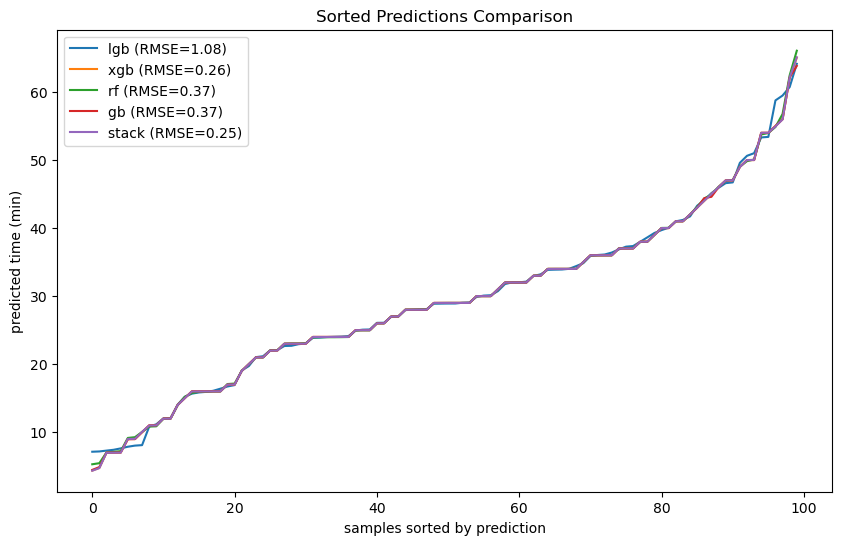

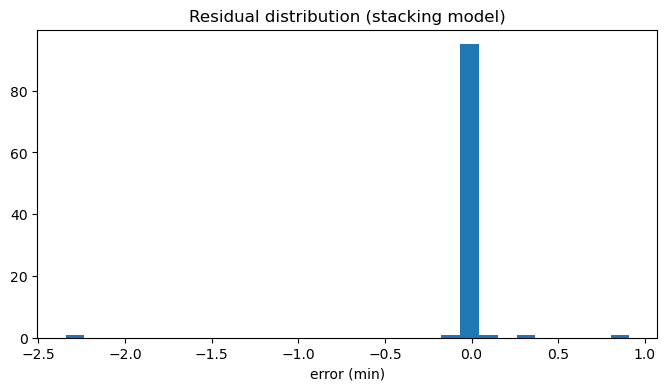

In [34]:
# Predictions from models for comparison
preds = {
    # 💥 CHANGE X_val to X_val_imputed 💥
    'lgb': trained_models['lgb'].predict(X_val_imputed),
    'xgb': trained_models['xgb'].predict(X_val_imputed),
    'rf': trained_models['rf'].predict(X_val_imputed),
    'gb': trained_models['gb'].predict(X_val_imputed),
    'stack': stack_pred # stack_pred was already calculated using X_val_imputed/array
}

plt.figure(figsize=(10,6))
for name, p in preds.items():
    rmse = np.sqrt(mean_squared_error(y_val, p))
    plt.plot(np.sort(p), label=f'{name} (RMSE={rmse:.2f})')
plt.title('Sorted Predictions Comparison')
plt.xlabel('samples sorted by prediction')
plt.ylabel('predicted time (min)')
plt.legend()
plt.show()

# Residual distribution for stacking model (This block is fine as written)
residuals = y_val - stack_pred
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title('Residual distribution (stacking model)')
plt.xlabel('error (min)')
plt.show()

## 13) Conclusion & next steps

- This notebook demonstrates an end-to-end enhanced pipeline.
- Replace sample data loading with your real dataset for production work.
- For deployment consider: containerization, model versioning, a proper feature store, and monitoring.

**Next steps you can take:**
- Run Optuna with more trials on a machine with more compute
- Add more granular traffic features from a real API
- Deploy the model behind a REST endpoint for real-time predictions
